In [1]:
!git clone https://github.com/Mingchenchen/pyFrustratometer.git


Cloning into 'pyFrustratometer'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 29 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (29/29), 85.92 KiB | 3.58 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [2]:
%cd pyFrustratometer
!pwd

/content/pyFrustratometer
/content/pyFrustratometer


In [3]:
!pip install biopython
!pip install py3Dmol

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.2 MB/s eta 0:00:00


In [1]:
import numpy as np
import math
import Bio.PDB
import numpy
from Bio.PDB.PDBParser import PDBParser
import os
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm as cm
import random
from utils import *
#from google.colab import files

In [5]:
## at this point, the upload function is not ready. wait for a few days.
#uploaded = files.upload()  # Upload files

In [2]:
huckel_flag = 1;
tert_frust_mode = "configurational";
#tert_frust_mode = "mutational";
tert_frust_cutoff= 9.5
tert_frust_ndecoys = 100;

In [3]:
def compute_native_ixn(rij, i_resno, j_resno, resname_list, rho, dist_matrix):
    i_resname = resname_list[i_resno];
    j_resname = resname_list[j_resno];
    reslen = len(rho);
    rho_i = rho[i_resno]
    rho_j = rho[j_resno]
    ires_type  = get_residue_type(i_resname)
    jres_type  = get_residue_type(j_resname)
    water_energy = compute_water_energy(rij, ires_type, jres_type, rho_i, rho_j)
    burial_energy_i = compute_burial_energy(ires_type, rho_i)
    burial_energy_j = compute_burial_energy(jres_type, rho_j)

    electrostatic_energy = 0
    if huckel_flag:
        electrostatic_energy = compute_electrostatic_energy(rij, i_resno, j_resno, i_resname, j_resname)

    if tert_frust_mode == "configurational":
        return water_energy + burial_energy_i + burial_energy_j + electrostatic_energy
    elif tert_frust_mode == "mutational":
        for k in range(reslen):
            if k == i_resno or k == j_resno:
                continue
            rho_k = rho[k]
            k_resname = resname_list[k]
            kres_type = get_residue_type(k_resname)
            rik = dist_matrix[i_resno, k]
            if rik < tert_frust_cutoff:
                water_energy += compute_water_energy(rik, ires_type, kres_type, rho_i, rho_k)
            if huckel_flag:
                electrostatic_energy += compute_electrostatic_energy(rik, i_resno, k, i_resname, k_resname)
            rjk = dist_matrix[j_resno, k]
            if rjk < tert_frust_cutoff:
                water_energy += compute_water_energy(rjk,  jres_type, kres_type, rho_j, rho_k)
            if huckel_flag:
                electrostatic_energy += compute_electrostatic_energy(rjk, j_resno, k, j_resname, k_resname)
        return water_energy + burial_energy_i + burial_energy_j + electrostatic_energy


In [9]:
def compute_decoy_ixns(i_resno, j_resno, resname_list, rho, dist_matrix):
    reslen = len(rho);
    rij_orig = dist_matrix[i_resno, j_resno];
    rho_i_orig = rho[i_resno];
    rho_j_orig = rho[j_resno];
    tert_frust_decoy_energies = np.zeros(tert_frust_ndecoys);
    for decoy_i in range(tert_frust_ndecoys):
        if tert_frust_mode == "configurational":
            rand_i_resno = random.randint(0, reslen - 1)
            rand_j_resno = random.randint(0, reslen - 1)
            rij = dist_matrix[rand_i_resno, rand_j_resno]
            while rij > tert_frust_cutoff or rand_i_resno == rand_j_resno:
                rand_i_resno = random.randint(0, reslen - 1)
                rand_j_resno = random.randint(0, reslen - 1)
                rij = dist_matrix[rand_i_resno, rand_j_resno]
            rand_i_resno_burial = random.randint(0, reslen - 1)
            rand_j_resno_burial = random.randint(0, reslen - 1)
            rho_i = rho[rand_i_resno_burial]
            rho_j = rho[rand_j_resno_burial]
        else:
            rij = rij_orig
            rho_i = rho_i_orig
            rho_j = rho_j_orig

        rand_i_resno = random.randint(0, reslen - 1)
        rand_j_resno = random.randint(0, reslen - 1)
        i_resname = resname_list[rand_i_resno];
        j_resname = resname_list[rand_j_resno]
        ires_type = get_residue_type(i_resname)
        jres_type = get_residue_type(j_resname)

        water_energy = compute_water_energy(rij, ires_type, jres_type, rho_i, rho_j)
        burial_energy_i = compute_burial_energy(ires_type, rho_i)
        burial_energy_j = compute_burial_energy(jres_type, rho_j)
        electrostatic_energy = compute_electrostatic_energy(rij, rand_i_resno, rand_j_resno, i_resname, j_resname) if huckel_flag else 0.0

        if tert_frust_mode == "mutational":
            for k in range(reslen):
                if k != i_resno and k != j_resno:
                    rho_k = rho[k]
                    k_resname = resname_list[k]
                    kres_type = get_residue_type(k_resname)
                    rik = dist_matrix[i_resno, k]
                    if rik < tert_frust_cutoff:
                        water_energy += compute_water_energy(rik, ires_type, kres_type, rho_i, rho_k)
                        electrostatic_energy += compute_electrostatic_energy(rik, rand_i_resno, k, i_resname, k_resname) if huckel_flag else 0.0
                    rjk = dist_matrix[j_resno, k]
                    if rjk < tert_frust_cutoff:
                        water_energy += compute_water_energy(rjk, jres_type, kres_type, rho_j, rho_k)
                        electrostatic_energy += compute_electrostatic_energy(rjk, rand_j_resno, k, j_resname, k_resname) if huckel_flag else 0.0

        tert_frust_decoy_energies[decoy_i] = water_energy + burial_energy_i + burial_energy_j + electrostatic_energy
    return np.mean(tert_frust_decoy_energies), np.std(tert_frust_decoy_energies) 

In [13]:
def compute_tert_frust(pdbcode):
    atomselect = 0;
    already_computed_configurational_decoys = 0;
    dist_matrix, cid_list, resname_list, ca_atoms = get_index_water(pdbcode);
    reslen = len(resname_list);
    rho = calc_rho(reslen, dist_matrix, cid_list);
    tert_frust_output_file = open('tertiary_frustration_' + tert_frust_mode + '.dat', 'w')
    tert_frust_vmd_script = open('tertiary_frustration_' + tert_frust_mode + '.tcl', 'w')
    frust_map = np.zeros((reslen, reslen))
    ##pymol script
    fpml = open('tertiary_frustration_' + tert_frust_mode + '.pml', 'w')
    fpml.write("hide all\n")
    fpml.write("unset dynamic_measures\n")
    fpml.write("show cartoon, all\n")
    fpml.write("color grey, all\n")
    fpml.write("run draw_links.py\n")
    e_mean_self = 0.0; 
    e_std_self = 0.0; 
    already_computed_configurational_decoys = 0; 
    # Double loop over all residue pairs
    for i in range(reslen):
        # get information about residue i
        i_resno = int(cid_list[i][1:])-1;
        i_resname = resname_list[i]
        ires_type = get_residue_type(i_resname)
        i_chno = cid_list[i][0]
        for j in range(i + 1, reslen):
            # get information about residue j
            j_resno = int(cid_list[j][1:])-1
            j_resname = resname_list[j]
            jres_type = get_residue_type(j_resname)
            j_chno = cid_list[j][0]
            # get the distance between i and j
            rij = dist_matrix[i, j]
            if (rij < tert_frust_cutoff and abs(i - j) >= 2) or (rij < tert_frust_cutoff and i_chno != j_chno):
                #print(rij, i, j, i_chno, j_chno, 'filtered')
                rho_i = rho[i_resno]
                rho_j = rho[j_resno]
                native_energy = compute_native_ixn(rij, i_resno, j_resno, resname_list, rho, dist_matrix)
                if tert_frust_mode == 'mutational':
                    e_mean_self, e_std_self = compute_decoy_ixns(i_resno, j_resno, resname_list, rho, dist_matrix);
                    e_mean, e_std = e_mean_self, e_std_self;
                if tert_frust_mode == "configurational" and already_computed_configurational_decoys == 0: 
                    e_mean_self, e_std_self = compute_decoy_ixns(i_resno, j_resno, resname_list, rho, dist_matrix);       
                    e_mean, e_std = e_mean_self, e_std_self;
                    already_computed_configurational_decoys = 1; 
                if tert_frust_mode == "configurational" and already_computed_configurational_decoys == 1:
                    e_mean, e_std = e_mean_self, e_std_self;
                frustration_index = (native_energy - e_mean) / e_std;
                # write information out to output file
                tert_frust_output_file.write(f"{i_resno + 1:>5} {j_resno + 1:>5} {i_chno} {j_chno} {rho_i:>8.3f} {rho_j:>8.3f} {resname_list[i_resno]} {resname_list[j_resno]} {native_energy:>8.3f} {e_mean:>8.3f} {e_std:>8.3f} {frustration_index:>8.3f} {ca_atoms[i][0]:>8.3f} {ca_atoms[i][1]:>8.3f} {ca_atoms[i][2]:>8.3f} {ca_atoms[j][0]:8.3f} {ca_atoms[j][1]:>8.3f} {ca_atoms[j][2]:>8.3f}\n")
                if frustration_index < -0.78 or frustration_index > 1:
                    # write information out to vmd script
                    tert_frust_vmd_script.write(f"set sel{i_resno} [atomselect top \"resid {i_resno + 1} and name CA\"]\n")
                    tert_frust_vmd_script.write(f"set sel{j_resno} [atomselect top \"resid {j_resno + 1} and name CA\"]\n")
                    tert_frust_vmd_script.write(f"lassign [atomselect{atomselect} get {{x y z}}] pos1\n")
                    atomselect += 1
                    tert_frust_vmd_script.write(f"lassign [atomselect{atomselect} get {{x y z}}] pos2\n")
                    atomselect += 1
                    frust_map[i, j] = frustration_index;
                    if frustration_index < -0.78:
                        tert_frust_vmd_script.write("draw color green\n")
                        fpml.write("draw_links resi " + str(i_resno+1) + " and name CA" + " and Chain " + i_chno + ", resi " + str(j_resno+1) +  " and name CA" + " and Chain " + j_chno + ", color=green, color2=green, radius=0.05, object_name=" + str(i_resno+1) +":"+ str(j_resno+1) + "_green" + i_chno + j_chno +  "\n" );

                    else:
                        tert_frust_vmd_script.write("draw color red\n");
                        fpml.write("draw_links resi " + str(i_resno+1) + " and name CA" + " and Chain " + i_chno + ", resi " + str(j_resno+1) +  " and name CA" + " and Chain " + j_chno + ", color=red, color2=red, radius=0.05, object_name=" + str(i_resno+1) +":"+ str(j_resno+1) + "red" + i_chno + j_chno +  "\n" );

                    if rij < well_r_max[0]:
                        tert_frust_vmd_script.write("draw line $pos1 $pos2 style solid width 1\n")
                    else:
                        tert_frust_vmd_script.write("draw line $pos1 $pos2 style dashed width 2\n")

    # after looping over all pairs, write out the end of the vmd script
    tert_frust_vmd_script.write("mol modselect 0 top \"all\"\n")
    tert_frust_vmd_script.write("mol modstyle 0 top newcartoon\n")
    tert_frust_vmd_script.write("mol modcolor 0 top colorid 15\n")
    tert_frust_vmd_script.close()
    tert_frust_output_file.close()
    fpml.write('select ligand, organic\n')
    fpml.write('select inorganiclig, inorganic\n')
    fpml.write('show spheres, inorganiclig\n')
    fpml.write('show sticks, ligand\n')
    fpml.write('color yellow, ligand\n')
    fpml.write('color magenta, inorganiclig\n')
    fpml.write("zoom all\n");
    fpml.write("hide labels\n");
    fpml.close()
    return frust_map

In [14]:
frust_map = compute_tert_frust('2PCC')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

245 769


/var/folders/hs/5kcddscn4dd1z6j0l4rmt3jw0000gn/T/ipykernel_9648/222204811.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Greys', 10)


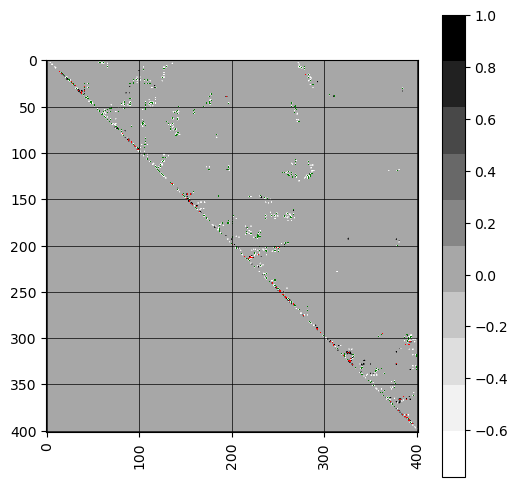

In [8]:
import py3Dmol
import pandas as pd
def visualize(pdbcode, datfile, frust_map):
    view = py3Dmol.view()
    view.addModel(open(pdbcode + '.pdb', 'r').read(),'pdb')
    #view.addSurface(py3Dmol.VDW,{'opacity':0.4,'color':'white'}, chA)
    view.setBackgroundColor('white')
    view.setStyle({'model':-1}, {'cartoon': {'color':'white'}})

    df = pd.read_csv(datfile, header=None, sep = "\s+")
    count_high = 0;
    count_low = 0;
    #frust_map = np.zeros((reslen, reslen))
    for i in range(len(df)):
        if df.iloc[i, 11] > 1.0 or df.iloc[i, 11] < -0.78:
            start_coord = [df.iloc[i, 12], df.iloc[i, 13], df.iloc[i, 14]]
            end_coord = [df.iloc[i, 15], df.iloc[i, 16], df.iloc[i, 17]]
            if df.iloc[i, 11] > 1.0:
                count_high += 1;
                #frust_map[df.iloc[i, 0]-1, df.iloc[i, 1]-1] = df.iloc[i, 11];
                view.addCylinder({
                        'start': {'x': start_coord[0], 'y': start_coord[1], 'z': start_coord[2]},
                        'end': {'x': end_coord[0], 'y': end_coord[1], 'z': end_coord[2]},
                        'radius': 0.08,
                        'fromCap': 1,
                        'toCap': 1,
                        'color': 'red',
                        'dashes': True
                })
            else:
                count_low += 1;
                #frust_map[df.iloc[i, 0]-1, df.iloc[i, 1]-1] = df.iloc[i, 11];
                view.addCylinder({
                        'start': {'x': start_coord[0], 'y': start_coord[1], 'z': start_coord[2]},
                        'end': {'x': end_coord[0], 'y': end_coord[1], 'z': end_coord[2]},
                        'radius': 0.08,
                        'fromCap': 1,
                        'toCap': 1,
                        'color': 'green',
                        'dashes': True
                })
    view.render()
    view.zoomTo()
    view.show()
    print(count_high, count_low)
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)

    cmap = cm.get_cmap('Greys', 10)
    cmap.set_under(color='green')
    cmap.set_over(color='red')
    cax = ax.imshow(frust_map, cmap=cmap, vmin=-0.78, vmax=1.0)
    ax.grid(color='black', linewidth=0.5, alpha=1)  # Setting grid color, linewidth, and alpha
    plt.colorbar(cax)
    ax.set_facecolor('white')  # Setting background color to white
    plt.xticks(fontsize=10, rotation=90)
    plt.yticks(fontsize=10)
    plt.savefig('frustration_map.png', dpi=300)
    plt.show()

visualize('2PCC', 'tertiary_frustration.dat', frust_map)

In [3]:
### implement the single residue mode
#def compute_singleresidue_native_ixn(i_resno, ires_type, rho_i, i_chno, cutoff, nmercalc):
def compute_singleresidue_native_ixn(i_resno, i_resname, rho_i, i_chno, resname_list, rho, cid_list, dist_matrix, cutoff):
    water_energy = 0.0
    #rho_i = rho[i_resno]
    ires_type = get_residue_type(i_resname);
    burial_energy_i = compute_burial_energy(ires_type, rho_i)
    electrostatic_energy = 0.0
    reslen = len(rho);
    #i_resname = resname_list[i_resno]; 
    #ires_type = get_residue_type(i_resname);
    #i_chno = cid_list[i_resno][0]
    for j in range(reslen):
        j_resno = j;
        j_resname = resname_list[j_resno]
        jres_type = get_residue_type(j_resname)
        j_chno = cid_list[j][0]
        rho_j = rho[j]
        if i_resno == j_resno:
            continue
        rij = dist_matrix[i_resno, j_resno]

        if rij < cutoff and (abs(i_resno - j_resno) >= 2 or i_chno != j_chno):
            water_energy += compute_water_energy(rij, ires_type, jres_type, rho_i, rho_j)

        if huckel_flag:
            electrostatic_energy += compute_electrostatic_energy(rij, i_resno, j_resno, i_resname, j_resname)

    return water_energy + burial_energy_i + electrostatic_energy


In [4]:
def compute_singleresidue_decoy_ixns(i_resno, ires_type, rho_i, i_chno, resname_list, rho, cid_list, dist_matrix):
    reslen = len(rho);
    tert_frust_ndecoys = 1000; 
    tert_frust_decoy_energies = np.zeros(tert_frust_ndecoys);
    for decoy_i in range(tert_frust_ndecoys):
        rand_i_resno = random.randint(0, reslen - 1)
        rand_i_resname = resname_list[rand_i_resno];
        #ires_type = get_residue_type(rand_i_resname);

        tert_frust_decoy_energies[decoy_i] = compute_singleresidue_native_ixn(i_resno,rand_i_resname, rho_i, i_chno, resname_list, rho, cid_list, dist_matrix, 9.5)

    return np.mean(tert_frust_decoy_energies), np.std(tert_frust_decoy_energies)



In [5]:
def compute_tert_frust_singleresidue(pdbcode):
    atomselect = 0  # for the vmd script output
    dist_matrix, cid_list, resname_list, ca_atoms = get_index_water(pdbcode);
    reslen = len(resname_list)
    rho = calc_rho(reslen, dist_matrix, cid_list);
    tert_frust_output_file = open('tertiary_frustration_singleresidue.dat', 'w')
    tert_frust_vmd_script = open('tertiary_frustration_singleresidue.tcl', 'w')
    for i in range(reslen):
        i_resno = int(cid_list[i][1:])-1;
        i_resname = resname_list[i]
        ires_type = get_residue_type(i_resname)
        rho_i = rho[i]
        i_chno = cid_list[i][0]

        native_energy = compute_singleresidue_native_ixn(i_resno, i_resname, rho_i, i_chno, resname_list, rho, cid_list, dist_matrix, 9.5);
        #print(native_energy)
        e_mean, e_std = compute_singleresidue_decoy_ixns(i_resno, ires_type, rho_i, i_chno, resname_list, rho, cid_list, dist_matrix);

        frustration_index = (native_energy - e_mean) / e_std;

        tert_frust_output_file.write(f"{i_resno + 1:>5} {i_chno} {rho_i:>8.3f} {resname_list[i_resno]} {native_energy:>8.3f} {e_mean:>8.3f} {e_std:>8.3f} {frustration_index:>8.3f} {ca_atoms[i][0]:>8.3f} {ca_atoms[i][1]:>8.3f} {ca_atoms[i][2]:>8.3f}\n")          
        # Write information out to vmd script
        atomselect += 1
        tert_frust_vmd_script.write("mol addrep 0\n")
        tert_frust_vmd_script.write("mol modselect %d 0 resid %d and chain %s\n" % (atomselect, i_resno+1, i_chno))
        tert_frust_vmd_script.write("mol modstyle %d 0 VDW %f 12.000000\n" % (atomselect, 0.5*abs(frustration_index)))
        tert_frust_vmd_script.write("mol modmaterial %d 0 Transparent\n" % atomselect)

        if frustration_index < 0.0:
            tert_frust_vmd_script.write("mol modcolor %d 0 ColorID 7\n" % atomselect)  # color the residue green
        else:
            tert_frust_vmd_script.write("mol modcolor %d 0 ColorID 1\n" % atomselect)  # color the residue red

    # After looping over all pairs, write out the end of the vmd script
    tert_frust_vmd_script.write("mol modselect 0 top \"all\"\n")
    tert_frust_vmd_script.write("mol modstyle 0 top newcartoon\n")
    tert_frust_vmd_script.write("mol modcolor 0 top colorid 15\n")
    tert_frust_vmd_script.close()
    tert_frust_output_file.close()


In [6]:
compute_tert_frust_singleresidue('2PCC')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

222 180


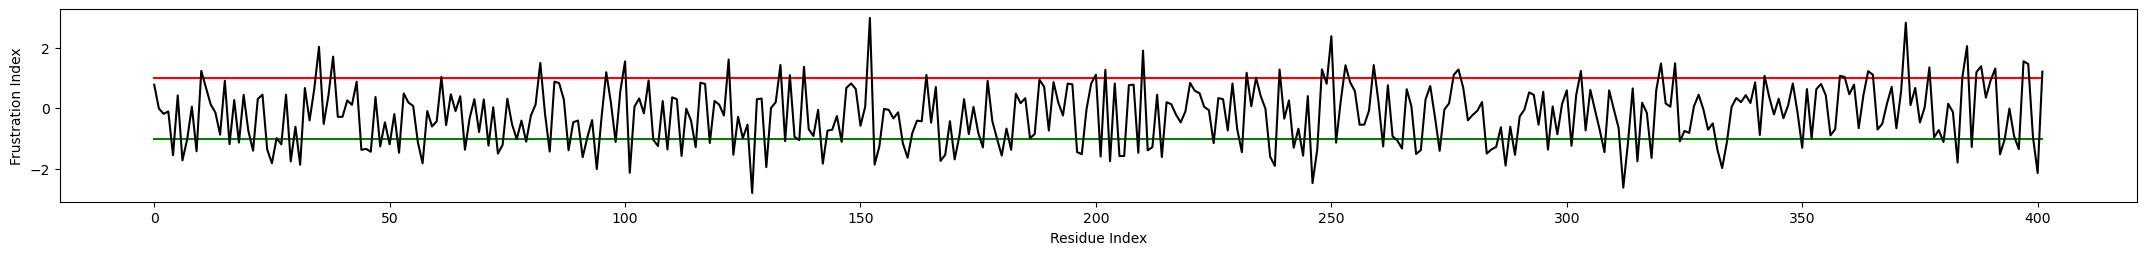

In [9]:
import py3Dmol
import pandas as pd
def visualize_single_residue(pdbcode, datfile):
    view = py3Dmol.view()
    view.addModel(open(pdbcode + '.pdb', 'r').read(),'pdb')
    view.setBackgroundColor('white')
    view.setStyle({'model':-1}, {'cartoon': {'color':'white'}})

    df = pd.read_csv(datfile, header=None, sep = "\s+")
    count_high = 0;
    count_low = 0;
    opacity_value = 0.8;
    #frust_map = np.zeros((reslen, reslen))
    for i in range(len(df)):
        #print(df.iloc[i, 7], df.iloc[i, 1], df.iloc[i, 0])
        if df.iloc[i, 7] < 0:
            count_high += 1;
            #frust_map[df.iloc[i, 0]-1, df.iloc[i, 1]-1] = df.iloc[i, 11];
            view.addStyle({'chain': str(df.iloc[i, 1]),'resi': float(df.iloc[i, 0])},{'sphere':{'color':'green', 'scale': 0.5*abs(float(df.iloc[i, 7])), 'opacity':opacity_value}})
        else:
            count_low += 1;
            #frust_map[df.iloc[i, 0]-1, df.iloc[i, 1]-1] = df.iloc[i, 11];
            view.addStyle({'chain': str(df.iloc[i, 1]),'resi': float(df.iloc[i, 0])},{'sphere':{'color':'red', 'scale': 0.5*abs(float(df.iloc[i, 7])), 'opacity':opacity_value}})
                
    view.render()
    view.zoomTo()
    view.show()
    print(count_high, count_low)
    fig=plt.figure(figsize=(len(df)/15,2.5))
    plt.plot(range(len(df)), [-1 for i in range(len(df))], color='green', linewidth = 1.5);
    plt.plot(range(len(df)), [1 for i in range(len(df))], color='red', linewidth = 1.5);
    plt.plot(df.iloc[:,7], color='black', linewidth = 1.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Residue Index',fontsize=10)
    plt.ylabel('Frustration Index',fontsize=10)
    plt.savefig('frustration_singleresidue.png');

visualize_single_residue('2PCC', 'tertiary_frustration_singleresidue.dat')